In [1]:
# ============================================================
# Mini-Project: Thailand Fatal Road Accident Classification
# Dataset: thailand_fatal_raod_accident_2011_2022.csv
# Target: vehicle_type (10 classes)
# ============================================================

# === STEP 0: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier

print("All libraries imported successfully.")

All libraries imported successfully.


# คำอธิบายเกี่ยวกับข้อมูล (Dataset Description)

ข้อมูลนี้เป็นข้อมูลอุบัติเหตุทางถนนที่มีผู้เสียชีวิตในประเทศไทย ตั้งแต่ปี 2011-2022 มีทั้งหมด **16 คอลัมน์** ดังนี้:

| # | คอลัมน์ | ประเภท | คำอธิบาย |
|---|---------|--------|----------|
| 1 | `accident_date` | datetime string | วันเวลาที่เกิดอุบัติเหตุ (มี missing values) |
| 2 | `official_death_date` | date string | วันที่เสียชีวิตอย่างเป็นทางการ |
| 3 | `age` | float | อายุของผู้เสียชีวิต (ช่วง 0-98 ปี, มี missing values) |
| 4 | `gender` | categorical | เพศ (Male / Female) |
| 5 | `nationality` | categorical | สัญชาติ (Thai / Unknown) |
| 6 | `accident_cause_code` | categorical | รหัสสาเหตุการเกิดอุบัติเหตุตามมาตรฐาน ICD (เช่น V299, V892) มี 231 ค่าที่แตกต่างกัน |
| 7 | `accident_cause` | text | คำอธิบายสาเหตุการเกิดอุบัติเหตุ (ข้อความยาว) |
| 8 | **`vehicle_type`** | **categorical (TARGET)** | **ประเภทยานพาหนะที่เกี่ยวข้อง** — เป็นตัวแปรเป้าหมาย มี 10 คลาส: moterbike, unidentified, car, pedestrian, small_truck_or_van, bus, tricycle, hevay_truck, bike, agricultural_vehicle |
| 9 | `province_th` | text | จังหวัด (ภาษาไทย) |
| 10 | `district_th` | text | อำเภอ (ภาษาไทย) |
| 11 | `sub_district_th` | text | ตำบล (ภาษาไทย) |
| 12 | `province_en` | text | จังหวัด (ภาษาอังกฤษ, 77 จังหวัด) |
| 13 | `district_en` | text | อำเภอ (ภาษาอังกฤษ, ~1,088 ค่า — cardinality สูง) |
| 14 | `sub_district_en` | text | ตำบล (ภาษาอังกฤษ, ~5,918 ค่า — cardinality สูงมาก) |
| 15 | `latitude` | float | ละติจูด (พิกัด GPS) |
| 16 | `longitude` | float | ลองจิจูด (พิกัด GPS) |

### หมายเหตุสำคัญ
- คอลัมน์ `accident_cause_code` มีรหัส ICD ที่ encode ประเภทยานพาหนะไว้ในตัว (เช่น V2xx = มอเตอร์ไซค์) ทำให้เกิด **data leakage** หากนำไปใช้ตรงๆ → จะแปลงเป็นกลุ่มกว้างๆ แทน
- คอลัมน์ภาษาไทย (`_th`) ซ้ำกับภาษาอังกฤษ (`_en`) → จะลบออก
- `district_en` และ `sub_district_en` มี cardinality สูงเกินไปสำหรับ one-hot encoding → จะใช้เฉพาะ `province_en`

Dataset Overview
จำนวนแถว (Samples) : 240,924
จำนวนคอลัมน์ (Features): 16
Duplicate rows          : 2,478

--- Data Types ---
accident_date           object
official_death_date     object
age                    float64
gender                  object
nationality             object
accident_cause_code     object
accident_cause          object
vehicle_type            object
province_th             object
district_th             object
sub_district_th         object
province_en             object
district_en             object
sub_district_en         object
latitude               float64
longitude              float64
dtype: object

--- Missing Values ---
accident_date          133974
official_death_date         0
age                     29814
gender                      0
nationality                 0
accident_cause_code         0
accident_cause              0
vehicle_type                0
province_th                 0
district_th                 0
sub_district_th             0
province_e

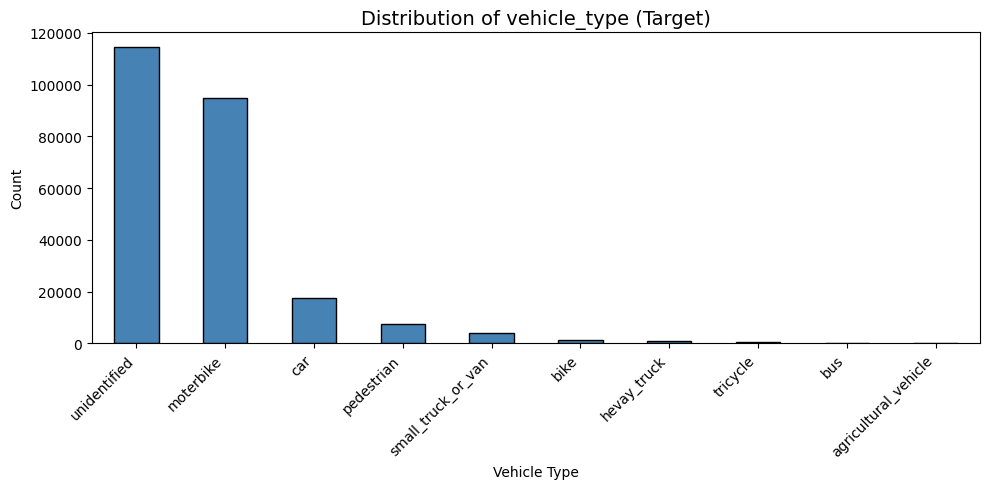

,accident_date,official_death_date,age,gender,nationality,accident_cause_code,accident_cause,vehicle_type,province_th,district_th,sub_district_th,province_en,district_en,sub_district_en,latitude,longitude
0,2011-01-01 00:25:00,2011-01-01,21.0,Male,Thai,V892,Person injured in unspecified motor-vehicle ac...,unidentified,เพชรบูรณ์,บึงสามพัน,บึงสามพัน,Phetchabun,Bueng Sam Phan,Bueng Sam Phan,15.794114,101.006878
1,2011-01-01 06:35:00,2011-01-01,23.0,Male,Thai,V299,Motorcycle rider [any] injured in unspecified ...,moterbike,สุราษฎร์ธานี,พนม,พังกาญจน์,Surat Thani,Phanom,Phangkan,8.916207,98.890434
2,2011-01-01 19:00:00,2011-01-01,26.0,Male,Thai,V234,Motorcycle rider injured in collision with car...,moterbike,ระยอง,บ้านฉาง,บ้านฉาง,Rayong,Ban Chang,Ban Chang,12.734329,101.065845
3,2011-01-01 02:00:00,2011-01-01,16.0,Male,Thai,V429,Car occupant injured in collision with two-or ...,car,พิษณุโลก,บางระกำ,ปลักแรด,Phitsanulok,Bang Rakam,Plak Rad,16.662980,100.120976
4,2011-01-01 02:00:00,2011-01-01,12.0,Male,Thai,V429,Car occupant injured in collision with two-or ...,car,พิษณุโลก,บางระกำ,ปลักแรด,Phitsanulok,Bang Rakam,Plak Rad,16.662980,100.120976
5,2011-01-01 00:25:00,2011-01-01,17.0,Male,Thai,V892,Person injured in unspecified motor-vehicle ac...,unidentified,เพชรบูรณ์,บึงสามพัน,บึงสามพัน,Phetchabun,Bueng Sam Phan,Bueng Sam Phan,15.794114,101.006878
6,2011-01-02 19:30:00,2011-01-02,16.0,Male,Thai,V299,Motorcycle rider [any] injured in unspecified ...,moterbike,ขอนแก่น,ไม่ระบุ,ไม่ระบุ,Khon Kaen,Unknown,Unknown,16.504403,102.407338
7,2011-01-02 08:45:00,2011-01-02,40.0,Male,Thai,V249,Motorcycle rider injured in collision with hea...,moterbike,ระยอง,แกลง,สองสลึง,Rayong,Klaeng,Song Salung,12.719909,101.297347
8,2011-01-02 19:00:00,2011-01-02,40.0,Female,Thai,V299,Motorcycle rider [any] injured in unspecified ...,moterbike,ตรัง,ห้วยยอด,เขากอบ,Trang,Huai Yot,Khao Kob,7.816994,99.581225
9,2011-01-02 19:00:00,2011-01-02,29.0,Male,Thai,V299,Motorcycle rider [any] injured in unspecified ...,moterbike,ตรัง,ห้วยยอด,เขากอบ,Trang,Huai Yot,Khao Kob,7.816994,99.581225


In [2]:
# ============================================================
# STEP 1: Load Data & Initial Exploration
# ============================================================

df = pd.read_csv("thailand_fatal_raod_accident_2011_2022.csv", low_memory=False)

print("=" * 60)
print("Dataset Overview")
print("=" * 60)
print(f"จำนวนแถว (Samples) : {df.shape[0]:,}")
print(f"จำนวนคอลัมน์ (Features): {df.shape[1]}")
print(f"Duplicate rows          : {df.duplicated().sum():,}")
print()

print("--- Data Types ---")
print(df.dtypes)
print()

print("--- Missing Values ---")
print(df.isnull().sum())
print()

print("--- Target Class Distribution (vehicle_type) ---")
print(df["vehicle_type"].value_counts())
print()

# แสดงกราฟ class distribution
fig, ax = plt.subplots(figsize=(10, 5))
df["vehicle_type"].value_counts().plot(kind="bar", ax=ax, color="steelblue", edgecolor="black")
ax.set_title("Distribution of vehicle_type (Target)", fontsize=14)
ax.set_xlabel("Vehicle Type")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df.head(10)

# หลักการและขั้นตอน: การเตรียมข้อมูล (Data Cleaning & Preprocessing)

## กระบวนการเตรียมข้อมูล
1. **กำจัดแถวซ้ำ (Duplicates)** — ลบแถวที่มีข้อมูลเหมือนกันทุกคอลัมน์ เพื่อป้องกัน bias
2. **กำจัด Missing Values:**
   - `age`: เติมด้วยค่า **median** (robust ต่อ outlier กว่า mean)
   - `accident_date`: ลบแถวที่เป็น NaN (จำเป็นต้องใช้สำหรับ feature engineering)
3. **กำจัด Noise (ค่าผิดปกติ):**
   - กรอง `latitude` ให้อยู่ในช่วง 5°N - 21°N (ขอบเขตประเทศไทย)
   - กรอง `longitude` ให้อยู่ในช่วง 97°E - 106°E
   - ค่าที่อยู่นอกช่วง → แทนที่ด้วย NaN แล้วเติมด้วย median
4. **Feature Engineering:**
   - สกัด `hour`, `day_of_week`, `month`, `year` จาก `accident_date`
   - แปลง `accident_cause_code` เป็นกลุ่มกว้าง (`cause_group`) เพื่อลด data leakage: collision / noncollision / unspecified / other
5. **ลบคอลัมน์ที่ไม่ใช้** — คอลัมน์ภาษาไทย, district/sub_district (cardinality สูง), วันที่ดิบ, accident_cause (text ยาว)
6. **Encoding:**
   - `gender`, `nationality` → Label Encoding
   - `province_en`, `cause_group` → One-Hot Encoding

In [3]:
# ============================================================
# STEP 2: Data Cleaning
# ============================================================

print("ก่อน cleaning:", df.shape)

# 2.1 ลบแถวซ้ำ
df = df.drop_duplicates()
print(f"หลังลบ duplicates: {df.shape}")

# 2.2 จัดการ Missing Values
# age: เติมด้วย median
age_median = df["age"].median()
df["age"] = df["age"].fillna(age_median)
print(f"เติม age NaN ด้วย median = {age_median}")

# accident_date: ไม่ลบ — จะ parse แล้วเติม NaN features ด้วย median ใน step ถัดไป
print(f"accident_date NaN: {df['accident_date'].isna().sum()} rows (จะเติม datetime features ด้วย median)")

# gender/nationality: เติม NaN ด้วย mode
df["gender"] = df["gender"].fillna(df["gender"].mode()[0])
df["nationality"] = df["nationality"].fillna("Unknown")

# accident_cause_code: เติม NaN ด้วย "Unknown"
df["accident_cause_code"] = df["accident_cause_code"].fillna("Unknown")
df["accident_cause"] = df["accident_cause"].fillna("Unknown")

# 2.3 จัดการ Noise ใน latitude / longitude
# ขอบเขตประเทศไทย: lat 5-21, lon 97-106
lat_mask = (df["latitude"] < 5) | (df["latitude"] > 21)
lon_mask = (df["longitude"] < 97) | (df["longitude"] > 106)

print(f"\nNoisy latitude: {lat_mask.sum()} rows")
print(f"Noisy longitude: {lon_mask.sum()} rows")

df.loc[lat_mask, "latitude"] = np.nan
df.loc[lon_mask, "longitude"] = np.nan

# เติม lat/lon ด้วย median
df["latitude"] = df["latitude"].fillna(df["latitude"].median())
df["longitude"] = df["longitude"].fillna(df["longitude"].median())

print(f"\nMissing values หลัง cleaning:")
print(df.isnull().sum())
print(f"\nDataset shape หลัง cleaning: {df.shape}")

ก่อน cleaning: (240924, 16)
หลังลบ duplicates: (238446, 16)
เติม age NaN ด้วย median = 38.0
accident_date NaN: 132022 rows (จะเติม datetime features ด้วย median)

Noisy latitude: 143 rows
Noisy longitude: 159 rows

Missing values หลัง cleaning:
accident_date          132022
official_death_date         0
age                         0
gender                      0
nationality                 0
accident_cause_code         0
accident_cause              0
vehicle_type                0
province_th                 0
district_th                 0
sub_district_th             0
province_en                 0
district_en                 0
sub_district_en             0
latitude                    0
longitude                   0
dtype: int64

Dataset shape หลัง cleaning: (238446, 16)


In [4]:
# ============================================================
# STEP 3: Feature Engineering & Encoding
# ============================================================

# 3.1 สกัด datetime features
df["accident_date"] = pd.to_datetime(df["accident_date"], errors="coerce")
df["hour"] = df["accident_date"].dt.hour
df["day_of_week"] = df["accident_date"].dt.dayofweek   # 0=Mon, 6=Sun
df["month"] = df["accident_date"].dt.month
df["year"] = df["accident_date"].dt.year

# เติม NaN ที่อาจเหลือจาก parsing errors
for col in ["hour", "day_of_week", "month", "year"]:
    df[col] = df[col].fillna(df[col].median())

print("Datetime features extracted: hour, day_of_week, month, year")

# 3.2 แปลง accident_cause_code เป็นกลุ่มกว้าง (ลด leakage)
def map_cause_group(code):
    """แปลงรหัส ICD เป็นกลุ่มกว้างๆ ตามประเภทเหตุการณ์ (ไม่ใช่ประเภทยานพาหนะ)"""
    if pd.isna(code) or code == "Unknown":
        return "unknown"
    code = str(code).strip().upper()
    # ดูตัวเลขหลังตัวอักษร V ตำแหน่งที่ 2-3 เพื่อจำแนกประเภทเหตุการณ์
    if len(code) >= 4:
        suffix = code[-1]  # ตัวเลขสุดท้ายบอกลักษณะผู้บาดเจ็บ
        mid = code[1:3] if len(code) >= 3 else ""
        # จำแนกตามลักษณะการเกิดเหตุ (ไม่ใช่ตามยานพาหนะ)
        if "collision" in str(code).lower():
            return "collision"
        # ดูจากตัวเลขกลาง (digit 2-3 ของ ICD code)
        try:
            num = int(code[1:3])
        except ValueError:
            return "other"
        # จำแนกตามหลักสุดท้าย: x4=driver, x5=passenger, x9=unspecified
        last_digit = code[-1]
        if last_digit in ["4", "0", "1"]:
            return "collision"
        elif last_digit in ["8"]:
            return "noncollision"
        elif last_digit in ["9", "2"]:
            return "unspecified"
        else:
            return "other"
    return "other"

df["cause_group"] = df["accident_cause_code"].apply(map_cause_group)
print(f"\ncause_group distribution:")
print(df["cause_group"].value_counts())

# 3.3 ลบคอลัมน์ที่ไม่ใช้
cols_to_drop = [
    "accident_date", "official_death_date",      # ใช้ datetime features แทน
    "accident_cause_code", "accident_cause",      # ใช้ cause_group แทน
    "province_th", "district_th", "sub_district_th",  # ซ้ำกับ _en
    "district_en", "sub_district_en",             # cardinality สูงเกินไป
]
df = df.drop(columns=cols_to_drop)
print(f"\nลบคอลัมน์: {cols_to_drop}")

# 3.4 Encoding
# gender: Label Encoding
df["gender"] = df["gender"].map({"Male": 1, "Female": 0}).fillna(0).astype(int)

# nationality: Label Encoding
df["nationality"] = df["nationality"].map({"Thai": 1, "Unknown": 0}).fillna(0).astype(int)

# province_en: One-Hot Encoding
df = pd.get_dummies(df, columns=["province_en"], drop_first=True, prefix="prov")

# cause_group: One-Hot Encoding
df = pd.get_dummies(df, columns=["cause_group"], drop_first=True, prefix="cause")

# 3.5 แยก X (features) และ y (target)
le = LabelEncoder()
y = le.fit_transform(df["vehicle_type"])
X = df.drop(columns=["vehicle_type"])

# แปลงคอลัมน์ทั้งหมดเป็น numeric (ป้องกัน error)
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

print(f"\n{'='*60}")
print(f"Feature Engineering Complete")
print(f"{'='*60}")
print(f"X shape: {X.shape}")
print(f"y classes: {le.classes_}")
print(f"y distribution: {np.unique(y, return_counts=True)}")
print(f"\nFeature list:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:3d}. {col}")

Datetime features extracted: hour, day_of_week, month, year

cause_group distribution:
cause_group
unspecified     151342
unknown          52834
collision        27048
other             7204
noncollision        18
Name: count, dtype: int64

ลบคอลัมน์: ['accident_date', 'official_death_date', 'accident_cause_code', 'accident_cause', 'province_th', 'district_th', 'sub_district_th', 'district_en', 'sub_district_en']

Feature Engineering Complete
X shape: (238446, 90)
y classes: ['agricultural_vehicle' 'bike' 'bus' 'car' 'hevay_truck' 'moterbike'
 'pedestrian' 'small_truck_or_van' 'tricycle' 'unidentified']
y distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([    94,   1126,    288,  17397,    884,  94643,   7420,   4016,
          376, 112202]))

Feature list:
    1. age
    2. gender
    3. nationality
    4. latitude
    5. longitude
    6. hour
    7. day_of_week
    8. month
    9. year
   10. prov_Ang Thong
   11. prov_Bangkok
   12. prov_Bueng Kan
   13. prov_Buri Ram
   1

# Feature Importance (Tree-based + Permutation Importance)

หากมีจำนวนลักษณะ (features) มากเกินไป ใช้ขั้นตอนวิธี **Tree-based GAIN ranking** ร่วมกับ **Permutation Importance** เพื่อลดจำนวนลักษณะลง

### ขั้นตอน (อ้างอิงจาก feature_importance.ipynb)
1. **Train XGBoost** บนข้อมูลทั้งหมด → คำนวณ GAIN importance
2. **เลือก top ⌈2/3⌉ features** ตามกฎ 2/3 Rule
3. **Retrain** ด้วย features ที่เลือก
4. **Permutation Importance** — สับเปลี่ยนค่าของ feature แต่ละตัวแล้ววัดว่า accuracy ลดลงเท่าไร
5. **จัดอันดับ** features ตามความสำคัญ

Baseline Accuracy (All 90 Features): 0.7435

Using 2/3 Rule → Selecting top 60 features out of 90
Accuracy after retraining (2/3 features): 0.7434

Permutation Importance Ranking (Top 20)
 rank               feature  importance_mean  importance_std
    1         cause_unknown         0.172840        0.000951
    2                  year         0.165557        0.001268
    3           nationality         0.103138        0.000773
    4     cause_unspecified         0.102853        0.001064
    5           cause_other         0.011621        0.000330
    6                   age         0.008066        0.000374
    7              latitude         0.004815        0.000494
    8             longitude         0.002327        0.000353
    9                gender         0.002302        0.000238
   10                  hour         0.001547        0.000408
   11            prov_Trang         0.001109        0.000158
   12       prov_Udon Thani         0.001095        0.000160
   13   prov_Kampha

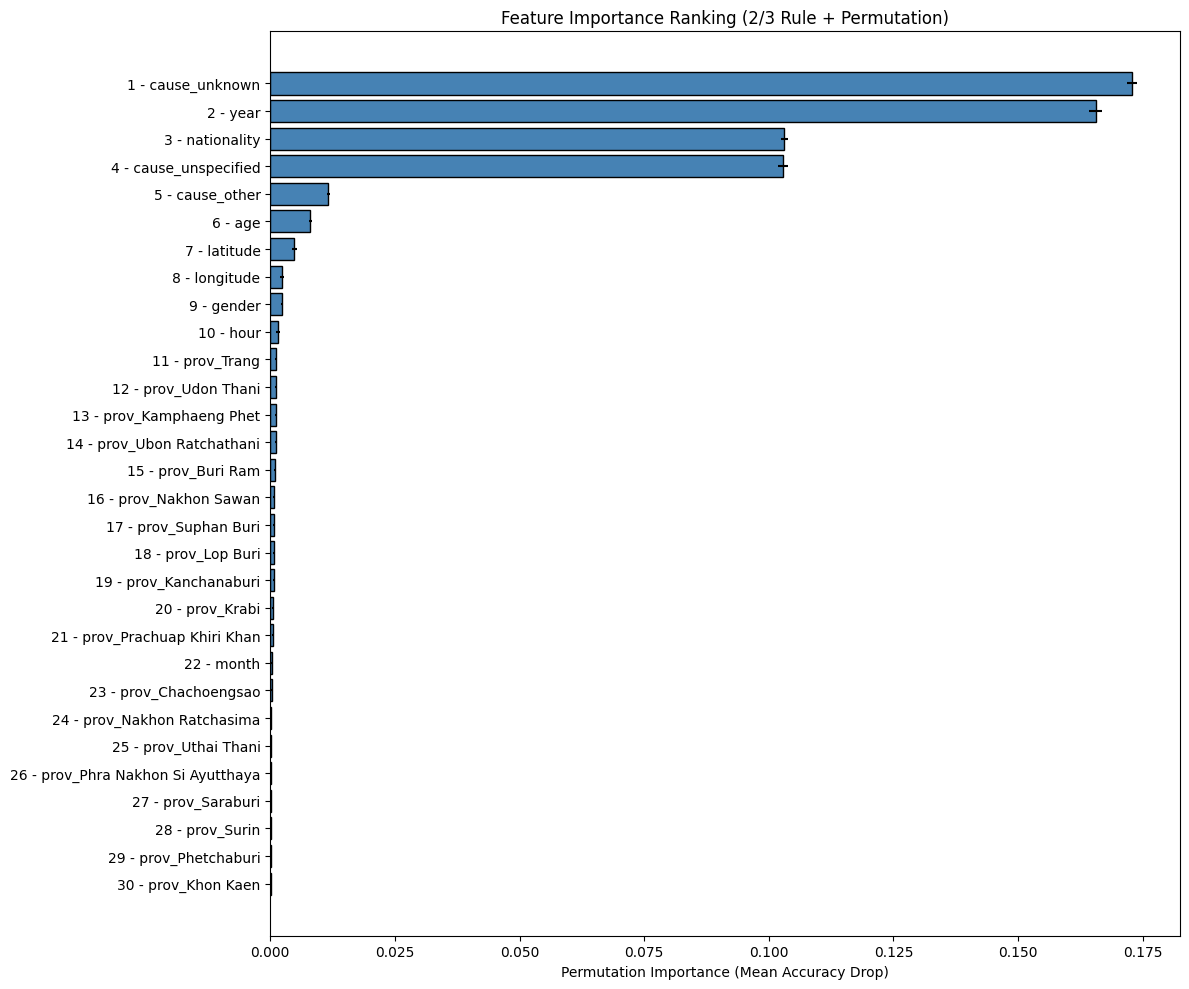


Top 3 Features:
  1. cause_unknown (importance = 0.1728 ± 0.0010)
  2. year (importance = 0.1656 ± 0.0013)
  3. nationality (importance = 0.1031 ± 0.0008)


In [5]:
# ============================================================
# STEP 4: Feature Importance (อ้างอิง feature_importance.ipynb)
# ============================================================

# 4.1 Train / Validation Split ชั่วคราว
X_train_fi, X_val_fi, y_train_fi, y_val_fi = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4.2 Train XGBoost Model (initial)
model_full = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="mlogloss",
    objective="multi:softprob",
    n_jobs=-1
)
model_full.fit(X_train_fi, y_train_fi)

baseline_acc = accuracy_score(y_val_fi, model_full.predict(X_val_fi))
print(f"Baseline Accuracy (All {X.shape[1]} Features): {baseline_acc:.4f}")

# 4.3 Tree-based Ranking (GAIN)
booster = model_full.get_booster()
score_dict = booster.get_score(importance_type="gain")

tree_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": [score_dict.get(f, 0) for f in X.columns]
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

# 4.4 Dynamic 2/3 Feature Selection
total_features = X.shape[1]
k = int(np.ceil((2/3) * total_features))
selected_features_fi = tree_importance.head(k)["feature"].tolist()

print(f"\nUsing 2/3 Rule → Selecting top {k} features out of {total_features}")

# 4.5 Retrain with selected features
model_selected = XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    eval_metric="mlogloss", objective="multi:softprob", n_jobs=-1
)
model_selected.fit(X_train_fi[selected_features_fi], y_train_fi)

selected_acc = accuracy_score(y_val_fi, model_selected.predict(X_val_fi[selected_features_fi]))
print(f"Accuracy after retraining (2/3 features): {selected_acc:.4f}")

# 4.6 Permutation Importance
perm = permutation_importance(
    model_selected,
    X_val_fi[selected_features_fi],
    y_val_fi,
    n_repeats=30,
    random_state=42,
    scoring="accuracy",
    n_jobs=-1
)

importance_df = pd.DataFrame({
    "feature": selected_features_fi,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values(by="importance_mean", ascending=False).reset_index(drop=True)

importance_df["rank"] = importance_df.index + 1
importance_df = importance_df[["rank", "feature", "importance_mean", "importance_std"]]

print("\n" + "=" * 60)
print("Permutation Importance Ranking (Top 20)")
print("=" * 60)
print(importance_df.head(20).to_string(index=False))

# 4.7 Plot
plt.figure(figsize=(12, 10))
top_n = min(30, len(importance_df))
plot_df = importance_df.head(top_n)
labels = plot_df["rank"].astype(str) + " - " + plot_df["feature"]
plt.barh(labels, plot_df["importance_mean"], xerr=plot_df["importance_std"],
         color="steelblue", edgecolor="black")
plt.xlabel("Permutation Importance (Mean Accuracy Drop)")
plt.title("Feature Importance Ranking (2/3 Rule + Permutation)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Top 3 Features:")
print("="*60)
for i in range(min(3, len(importance_df))):
    row = importance_df.iloc[i]
    print(f"  {int(row['rank'])}. {row['feature']} "
          f"(importance = {row['importance_mean']:.4f} ± {row['importance_std']:.4f})")

# Feature Selection (Nested Cross-Validation)

ใช้ **Nested Cross-Validation** เพื่อหาจำนวน features ที่เหมาะสม (อ้างอิงจาก feature_selection.ipynb)

### ขั้นตอน
1. **Outer CV (5-fold):** ใช้ประเมินผลโมเดลสุดท้าย
2. **Inner CV (3-fold):** ใช้ค้นหาจำนวน features (k) ที่ดีที่สุด สำหรับแต่ละ Outer Fold
3. **สรุป:** ใช้ค่า **Median** ของ best k จากทุก fold เป็นจำนวน features ที่แนะนำ

In [6]:
# ============================================================
# STEP 5: Feature Selection via Nested CV (อ้างอิง feature_selection.ipynb)
# ============================================================

# ใช้ feature ranking จาก tree_importance ที่ได้จาก Step 4
sorted_features_all = tree_importance["feature"].tolist()

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

outer_results = []
outer_best_k = []
min_k = 5

# จำกัดจำนวน k ที่ทดสอบเพื่อประหยัดเวลา (ทดสอบทุก 10 features)
k_range = list(range(min_k, len(sorted_features_all) + 1, 10))
if len(sorted_features_all) not in k_range:
    k_range.append(len(sorted_features_all))

print("Testing k values:", k_range[:10], "...", k_range[-3:])
print(f"Total k values to test per fold: {len(k_range)}")
print()

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"===== Outer Fold {fold_idx+1} =====")

    X_train_outer = X.iloc[train_idx]
    y_train_outer = y[train_idx]
    X_test_outer = X.iloc[test_idx]
    y_test_outer = y[test_idx]

    # Train model for tree importance (this fold)
    model_fo = XGBClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        eval_metric="mlogloss", objective="multi:softprob", n_jobs=-1
    )
    model_fo.fit(X_train_outer, y_train_outer)

    booster_fo = model_fo.get_booster()
    score_dict_fo = booster_fo.get_score(importance_type="gain")
    sorted_features = pd.DataFrame({
        "feature": X.columns,
        "importance": [score_dict_fo.get(col, 0) for col in X.columns]
    }).sort_values(by="importance", ascending=False)["feature"].tolist()

    # Inner CV to find best k
    performance_records = []
    for k_val in k_range:
        sel_feats = sorted_features[:k_val]
        fold_scores = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_tr = X_train_outer.iloc[inner_train_idx][sel_feats]
            y_tr = y_train_outer[inner_train_idx]
            X_va = X_train_outer.iloc[inner_val_idx][sel_feats]
            y_va = y_train_outer[inner_val_idx]

            model_in = XGBClassifier(
                n_estimators=100, max_depth=4, learning_rate=0.1,
                subsample=0.8, colsample_bytree=0.8, random_state=42,
                eval_metric="mlogloss", objective="multi:softprob", n_jobs=-1
            )
            model_in.fit(X_tr, y_tr)
            preds = model_in.predict(X_va)
            fold_scores.append(accuracy_score(y_va, preds))
        performance_records.append((k_val, np.mean(fold_scores)))

    perf_df = pd.DataFrame(performance_records, columns=["num_features", "cv_accuracy"])
    best_k_val = int(perf_df.loc[perf_df["cv_accuracy"].idxmax(), "num_features"])
    print(f"  Best k from Inner CV: {best_k_val}")
    outer_best_k.append(best_k_val)

    # Retrain with best_k on full outer train
    best_feats = sorted_features[:best_k_val]
    model_fin = XGBClassifier(
        n_estimators=100, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42,
        eval_metric="mlogloss", objective="multi:softprob", n_jobs=-1
    )
    model_fin.fit(X_train_outer[best_feats], y_train_outer)
    outer_acc = accuracy_score(y_test_outer, model_fin.predict(X_test_outer[best_feats]))
    print(f"  Outer Fold Accuracy: {outer_acc:.4f}\n")
    outer_results.append(outer_acc)

# Summary
outer_results = np.array(outer_results)
outer_best_k = np.array(outer_best_k)

print("=" * 60)
print("Nested CV Results")
print("=" * 60)
print(f"Outer Fold Accuracies: {np.round(outer_results, 4)}")
print(f"Mean Nested CV Accuracy: {np.mean(outer_results):.4f}")
print(f"Std Nested CV Accuracy: {np.std(outer_results):.4f}")
print(f"\nBest k per fold: {outer_best_k.tolist()}")
print(f"Mean best k: {np.mean(outer_best_k):.2f}")
print(f"Median best k: {int(np.median(outer_best_k))}")
print(f"Std of best k: {np.std(outer_best_k):.2f}")

recommended_k = int(np.median(outer_best_k))
print(f"\n>>> Recommended number of features (Median-based): {recommended_k}")

Testing k values: [5, 15, 25, 35, 45, 55, 65, 75, 85, 90] ... [75, 85, 90]
Total k values to test per fold: 10

===== Outer Fold 1 =====
  Best k from Inner CV: 85
  Outer Fold Accuracy: 0.7426

===== Outer Fold 2 =====
  Best k from Inner CV: 85
  Outer Fold Accuracy: 0.7414

===== Outer Fold 3 =====
  Best k from Inner CV: 85
  Outer Fold Accuracy: 0.7448

===== Outer Fold 4 =====
  Best k from Inner CV: 85
  Outer Fold Accuracy: 0.7449

===== Outer Fold 5 =====
  Best k from Inner CV: 90
  Outer Fold Accuracy: 0.7421

Nested CV Results
Outer Fold Accuracies: [0.7426 0.7414 0.7448 0.7449 0.7421]
Mean Nested CV Accuracy: 0.7432
Std Nested CV Accuracy: 0.0014

Best k per fold: [85, 85, 85, 85, 90]
Mean best k: 86.00
Median best k: 85
Std of best k: 2.00

>>> Recommended number of features (Median-based): 85


In [7]:
# ============================================================
# STEP 6: Apply Feature Selection — แสดง features ที่เหลือ
# ============================================================

# ใช้ recommended_k จาก Nested CV และ ranking จาก tree_importance
final_selected_features = tree_importance.head(recommended_k)["feature"].tolist()

print(f"{'='*60}")
print(f"Feature Selection Result")
print(f"{'='*60}")
print(f"จำนวน features เดิม: {X.shape[1]}")
print(f"จำนวน features ที่เลือก: {recommended_k}")
print(f"จำนวน features ที่ถูกลบ: {X.shape[1] - recommended_k}")
print(f"\nFeatures ที่เหลือหลัง Feature Selection:")
for i, feat in enumerate(final_selected_features, 1):
    imp_val = tree_importance.loc[tree_importance["feature"] == feat, "importance"].values[0]
    print(f"  {i:3d}. {feat:<40s} (GAIN = {imp_val:.2f})")

# อัปเดต X ให้เหลือเฉพาะ features ที่เลือก
X = X[final_selected_features]
print(f"\nX shape หลัง Feature Selection: {X.shape}")

Feature Selection Result
จำนวน features เดิม: 90
จำนวน features ที่เลือก: 85
จำนวน features ที่ถูกลบ: 5

Features ที่เหลือหลัง Feature Selection:
    1. cause_unknown                            (GAIN = 250.91)
    2. cause_unspecified                        (GAIN = 162.58)
    3. year                                     (GAIN = 138.99)
    4. cause_other                              (GAIN = 88.58)
    5. prov_Ubon Ratchathani                    (GAIN = 57.61)
    6. nationality                              (GAIN = 43.16)
    7. prov_Nonthaburi                          (GAIN = 28.19)
    8. prov_Pathum Thani                        (GAIN = 15.63)
    9. prov_Lop Buri                            (GAIN = 15.23)
   10. prov_Buri Ram                            (GAIN = 15.11)
   11. prov_Kamphaeng Phet                      (GAIN = 13.70)
   12. month                                    (GAIN = 13.65)
   13. prov_Udon Thani                          (GAIN = 13.08)
   14. prov_Trang               

# เทคนิคที่ใช้: การจัดเตรียมข้อมูลสำหรับสร้างแบบจำลอง

## การแบ่งข้อมูล (80/20 Split)
- **Cross Validation Set (80%)**: ใช้สร้างแบบจำลองและทวนสอบ (Grid Search + k-Fold CV)
- **Evaluation Set (20%)**: ใช้ทดสอบปัญหาการเข้ากันมากเกินไป (Overfitting) — **ไม่ถูกใช้ในการ train เลย**

## เทคนิคการจำแนกประเภท 3 วิธี
1. **kNN (k-Nearest Neighbors)** — จำแนกโดยอาศัยเพื่อนบ้านที่ใกล้ที่สุด + Grid Search
2. **XGBoost** — Gradient Boosted Trees + Grid Search
3. **Neural Network (MLP)** — Multi-Layer Perceptron + EarlyStopping + Regularization

## การค้นหา Hyperparameter
- ใช้ **GridSearchCV** กับ **10-Fold Stratified Cross-Validation** บน CV Set
- แสดงค่า **Best Parameter Set** ของแต่ละเทคนิค

In [8]:
# ============================================================
# STEP 7: แบ่งข้อมูล 80/20 (CV Set / Evaluation Set)
# ============================================================

X_cv, X_eval, y_cv, y_eval = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"{'='*60}")
print("Data Split (80/20)")
print(f"{'='*60}")
print(f"CV Set       : {X_cv.shape[0]:,} samples x {X_cv.shape[1]} features")
print(f"Evaluation Set: {X_eval.shape[0]:,} samples x {X_eval.shape[1]} features")
print(f"\ny_cv distribution : {np.unique(y_cv, return_counts=True)}")
print(f"y_eval distribution: {np.unique(y_eval, return_counts=True)}")

Data Split (80/20)
CV Set       : 190,756 samples x 85 features
Evaluation Set: 47,690 samples x 85 features

y_cv distribution : (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([   75,   901,   230, 13918,   707, 75714,  5936,  3213,   301,
       89761]))
y_eval distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([   19,   225,    58,  3479,   177, 18929,  1484,   803,    75,
       22441]))


## เทคนิคที่ 1: kNN (k-Nearest Neighbors)

- ใช้ **Pipeline** รวม `StandardScaler` + `KNeighborsClassifier`
- ค้นหา Hyperparameter ด้วย **GridSearchCV** (10-Fold Stratified CV)
- Parameter Grid:
  - `n_neighbors`: [3, 5, 7, 9, 11, 13, 15]
  - `weights`: [uniform, distance]
  - `metric`: [euclidean, manhattan]

In [9]:
# ============================================================
# STEP 8: kNN Classification + Grid Search
# ============================================================

pipeline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 13, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]
}

grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print("Training kNN with GridSearchCV (10-Fold CV)...")
grid_knn.fit(X_cv, y_cv)

print(f"\n{'='*60}")
print("kNN Results")
print(f"{'='*60}")
print(f"Best Parameters: {grid_knn.best_params_}")
print(f"Best CV Accuracy: {grid_knn.best_score_:.4f}")

# Evaluation Set
knn_best = grid_knn.best_estimator_
y_eval_pred_knn = knn_best.predict(X_eval)
knn_eval_acc = accuracy_score(y_eval, y_eval_pred_knn)

print(f"Evaluation Set Accuracy: {knn_eval_acc:.4f}")
print(f"CV - Eval Gap: {grid_knn.best_score_ - knn_eval_acc:.4f}")

print(f"\nClassification Report (Evaluation Set):")
print(classification_report(y_eval, y_eval_pred_knn, target_names=le.classes_))

Training kNN with GridSearchCV (10-Fold CV)...
Fitting 10 folds for each of 28 candidates, totalling 280 fits

kNN Results
Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Best CV Accuracy: 0.7192
Evaluation Set Accuracy: 0.7219
CV - Eval Gap: -0.0027

Classification Report (Evaluation Set):
                      precision    recall  f1-score   support

agricultural_vehicle       0.00      0.00      0.00        19
                bike       0.00      0.00      0.00       225
                 bus       0.14      0.03      0.06        58
                 car       0.34      0.13      0.19      3479
         hevay_truck       0.08      0.01      0.01       177
           moterbike       0.74      0.71      0.73     18929
          pedestrian       0.51      0.15      0.23      1484
  small_truck_or_van       0.35      0.10      0.16       803
            tricycle       0.00      0.00      0.00        75
        unidentified       0.73      0

## เทคนิคที่ 2: XGBoost

- ใช้ `XGBClassifier` สำหรับ multiclass classification (`multi:softprob`)
- ค้นหา Hyperparameter ด้วย **GridSearchCV** (10-Fold Stratified CV)
- Parameter Grid:
  - `n_estimators`: [100, 300]
  - `max_depth`: [3, 4, 6]
  - `learning_rate`: [0.05, 0.1]
  - `subsample`: [0.8]
  - `colsample_bytree`: [0.8]

In [10]:
# ============================================================
# STEP 9: XGBoost Classification + Grid Search
# ============================================================

param_grid_xgb = {
    "n_estimators": [100, 300],
    "max_depth": [3, 4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

xgb_base = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

grid_xgb = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print("Training XGBoost with GridSearchCV (10-Fold CV)...")
grid_xgb.fit(X_cv, y_cv)

print(f"\n{'='*60}")
print("XGBoost Results")
print(f"{'='*60}")
print(f"Best Parameters: {grid_xgb.best_params_}")
print(f"Best CV Accuracy: {grid_xgb.best_score_:.4f}")

# Evaluation Set
xgb_best = grid_xgb.best_estimator_
y_eval_pred_xgb = xgb_best.predict(X_eval)
xgb_eval_acc = accuracy_score(y_eval, y_eval_pred_xgb)

print(f"Evaluation Set Accuracy: {xgb_eval_acc:.4f}")
print(f"CV - Eval Gap: {grid_xgb.best_score_ - xgb_eval_acc:.4f}")

print(f"\nClassification Report (Evaluation Set):")
print(classification_report(y_eval, y_eval_pred_xgb, target_names=le.classes_))

Training XGBoost with GridSearchCV (10-Fold CV)...
Fitting 10 folds for each of 12 candidates, totalling 120 fits

XGBoost Results
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Best CV Accuracy: 0.7576
Evaluation Set Accuracy: 0.7584
CV - Eval Gap: -0.0008

Classification Report (Evaluation Set):
                      precision    recall  f1-score   support

agricultural_vehicle       0.00      0.00      0.00        19
                bike       0.00      0.00      0.00       225
                 bus       0.33      0.02      0.03        58
                 car       0.46      0.10      0.17      3479
         hevay_truck       0.30      0.02      0.03       177
           moterbike       0.79      0.75      0.77     18929
          pedestrian       0.64      0.23      0.34      1484
  small_truck_or_van       0.39      0.08      0.13       803
            tricycle       0.33      0.01      0.03        75
       

## เทคนิคที่ 3: Neural Network (MLP)

- ใช้ `MLPClassifier` จาก scikit-learn สำหรับ multiclass classification
- ค้นหา Hyperparameter ด้วย **GridSearchCV** (10-Fold Stratified CV)
- Parameter Grid:
  - `hidden_layer_sizes`: [(128, 64), (64, 32), (256, 128)]
  - `alpha` (L2 regularization): [0.0001, 0.001, 0.01]
  - `learning_rate`: [constant, adaptive]
- Scale ข้อมูลด้วย `StandardScaler` ใน Pipeline
- ใช้ `early_stopping=True` เพื่อป้องกัน Overfitting

In [ ]:
# ============================================================
# STEP 10: Neural Network (MLP) Classification + Grid Search
# ============================================================

pipeline_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=15,
        random_state=42
    ))
])

param_grid_mlp = {
    "mlp__hidden_layer_sizes": [(128, 64), (64, 32)],
    "mlp__alpha": [0.001, 0.01],
    "mlp__learning_rate": ["constant", "adaptive"],
}

grid_mlp = GridSearchCV(
    estimator=pipeline_mlp,
    param_grid=param_grid_mlp,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print("Training MLP with GridSearchCV (10-Fold CV)...")
grid_mlp.fit(X_cv, y_cv)

print(f"\n{'='*60}")
print("Neural Network (MLP) Results")
print(f"{'='*60}")
print(f"Best Parameters: {grid_mlp.best_params_}")
print(f"Best CV Accuracy: {grid_mlp.best_score_:.4f}")

# Evaluation Set
mlp_best = grid_mlp.best_estimator_
y_eval_pred_mlp = mlp_best.predict(X_eval)
mlp_eval_acc = accuracy_score(y_eval, y_eval_pred_mlp)

nn_cv_acc = grid_mlp.best_score_

print(f"Evaluation Set Accuracy: {mlp_eval_acc:.4f}")
print(f"CV - Eval Gap: {nn_cv_acc - mlp_eval_acc:.4f}")

print(f"\nClassification Report (Evaluation Set):")
print(classification_report(y_eval, y_eval_pred_mlp, target_names=le.classes_))

Training MLP with GridSearchCV (10-Fold CV)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


# การประเมินประสิทธิภาพของแบบจำลอง (Model Evaluation & Comparison)

## เปรียบเทียบผลทั้ง 3 เทคนิค
- แสดงตัวเลขประสิทธิภาพจาก **CV Set** และ **Evaluation Set**
- คำนวณค่าความต่าง (Gap) เพื่อวิเคราะห์ **Overfitting / Underfitting**
- Confusion Matrix สำหรับแต่ละเทคนิค
- สรุปว่าควรเลือกใช้เทคนิคใด

In [ ]:
# ============================================================
# STEP 11: เปรียบเทียบผลทั้ง 3 โมเดล
# ============================================================

# รวบรวมผลลัพธ์
results = pd.DataFrame({
    "Model": ["kNN", "XGBoost", "MLP (Neural Network)"],
    "CV Accuracy": [
        grid_knn.best_score_,
        grid_xgb.best_score_,
        grid_mlp.best_score_
    ],
    "Eval Accuracy": [
        knn_eval_acc,
        xgb_eval_acc,
        mlp_eval_acc
    ]
})

results["Gap (CV - Eval)"] = results["CV Accuracy"] - results["Eval Accuracy"]
results["Overfitting?"] = results["Gap (CV - Eval)"].apply(
    lambda x: "Yes (Gap > 5%)" if x > 0.05
    else ("Possible Underfitting" if x < -0.02 else "No")
)

print("=" * 70)
print("Model Comparison Summary")
print("=" * 70)
print(results.to_string(index=False))
print()

# Best Parameters Summary
print("\n--- Best Parameters ---")
print(f"kNN    : {grid_knn.best_params_}")
print(f"XGBoost: {grid_xgb.best_params_}")
print(f"MLP    : {grid_mlp.best_params_}")

# ============================================================
# Confusion Matrices
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

models_preds = [
    ("kNN", y_eval_pred_knn),
    ("XGBoost", y_eval_pred_xgb),
    ("MLP", y_eval_pred_mlp)
]

for ax, (name, y_pred) in zip(axes, models_preds):
    cm = confusion_matrix(y_eval, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, values_format="d")
    ax.set_title(f"Confusion Matrix: {name}", fontsize=13)

plt.tight_layout()
plt.show()

# ============================================================
# Bar Chart: CV vs Eval Accuracy
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results))
width = 0.35

bars1 = ax.bar(x - width/2, results["CV Accuracy"], width,
               label="CV Accuracy", color="steelblue", edgecolor="black")
bars2 = ax.bar(x + width/2, results["Eval Accuracy"], width,
               label="Eval Accuracy", color="coral", edgecolor="black")

ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.set_title("Cross-Validation vs Evaluation Accuracy Comparison")
ax.set_xticks(x)
ax.set_xticklabels(results["Model"])
ax.legend()
ax.set_ylim(0, 1.05)

# แสดงตัวเลขบน bar
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# สรุปผลลัพธ์ (Conclusion)

---

## 1. สรุปข้อมูล
- Dataset: อุบัติเหตุทางถนนที่มีผู้เสียชีวิตในประเทศไทย 2011-2022 (240,000+ rows)
- Target: `vehicle_type` — 10 คลาส (moterbike, car, unidentified, pedestrian, small_truck_or_van, bus, tricycle, hevay_truck, bike, agricultural_vehicle)
- ปัญหาหลัก: **Class Imbalance** (moterbike เป็นคลาสที่มีมากที่สุด), **High cardinality** (location columns), **Data leakage** (accident_cause_code)

## 2. การเตรียมข้อมูล
- ลบ duplicates (~2,400+ rows)
- เติม missing values: age → median, lat/lon → กรองช่วงที่ถูกต้องแล้วเติม median
- สกัด datetime features: hour, day_of_week, month, year
- แปลง accident_cause_code เป็นกลุ่มกว้าง (collision/noncollision/unspecified/other) เพื่อลด data leakage
- ใช้เฉพาะ province_en (one-hot encoding) สำหรับ location → ลด cardinality

## 3. Feature Importance & Selection
- ใช้ **Tree-based GAIN + Permutation Importance** (ตาม feature_importance.ipynb) เพื่อจัดอันดับ features
- ใช้ **Nested Cross-Validation** (ตาม feature_selection.ipynb) เพื่อหาจำนวน features ที่เหมาะสม
- ลดจำนวน features จากทั้งหมดเหลือตาม recommended k

## 4. เปรียบเทียบเทคนิคการจำแนกประเภท

### kNN (k-Nearest Neighbors)
**ข้อดี:**
- เข้าใจง่าย ไม่มี training phase ที่ซับซ้อน
- ไม่ต้องมีสมมติฐานเกี่ยวกับ data distribution
- ดีกับ decision boundary ที่ไม่เป็นเส้นตรง

**ข้อเสีย:**
- **ช้ามากกับข้อมูลขนาดใหญ่** (ต้องคำนวณระยะทางทุกครั้ง)
- Sensitive ต่อ feature scaling (ต้อง StandardScaler)
- ไม่ดีกับ high-dimensional data (curse of dimensionality)
- ไม่สามารถจัดการ class imbalance ได้ดี

### XGBoost
**ข้อดี:**
- **ประสิทธิภาพสูง** — ensemble ของ decision trees
- จัดการ **class imbalance** ได้ด้วย class weights
- ทนต่อ noise และ outliers
- สามารถจัดการ missing values ได้ในตัว
- ให้ feature importance ที่เป็นประโยชน์

**ข้อเสีย:**
- ต้อง tune hyperparameters หลายตัว
- อาจ overfit ถ้า depth สูงเกินไป
- ใช้เวลา train นานกับ Grid Search หลายพารามิเตอร์

### Neural Network (MLP)
**ข้อดี:**
- เรียนรู้ **non-linear patterns** ที่ซับซ้อนได้
- มี Regularization หลายวิธี (L2/alpha, EarlyStopping)
- ยืดหยุ่นในการออกแบบสถาปัตยกรรม
- GridSearchCV ช่วยหา architecture ที่เหมาะสม

**ข้อเสีย:**
- ต้องการ **ข้อมูลจำนวนมาก** เพื่อให้ทำงานได้ดี
- **Train ช้า** กว่าวิธีอื่น
- ต้อง tune architecture (จำนวน layers, units, alpha)
- ไม่สามารถตีความได้ง่าย (black box)
- Sensitive ต่อ feature scaling

## 5. Overfitting / Underfitting Analysis
- **Gap (CV - Eval) > 5%** → สัญญาณ **Overfitting** — โมเดลจำข้อมูล train ดีเกินไป ทำให้ผลบน Evaluation Set ลดลง
- **Gap ≈ 0%** → โมเดลมี **generalization ที่ดี**
- **Eval > CV (Gap < 0)** → อาจเกิดจาก **randomness** หรือ **Underfitting** เล็กน้อย

## 6. คำแนะนำ
- สำหรับ dataset ที่มีขนาดใหญ่ (240K+ rows) และ class imbalance, **XGBoost** มักเป็นตัวเลือกที่ดีที่สุด เพราะ:
  - จัดการ imbalanced class ได้
  - ไม่ต้อง scale ข้อมูล
  - ให้ feature importance ที่ช่วยตีความได้
  - ทนต่อ noise
- ดูจากตารางเปรียบเทียบ accuracy ด้านบน เพื่อยืนยันว่าเทคนิคใดได้ผลดีที่สุดสำหรับข้อมูลชุดนี้

In [ ]:
# ============================================================
# STEP 12: สรุปผลลัพธ์สุดท้าย (Final Summary Table)
# ============================================================

print("=" * 70)
print("FINAL MODEL COMPARISON SUMMARY")
print("=" * 70)
print()
print(results.to_string(index=False))
print()

# หาโมเดลที่ดีที่สุด
best_idx = results["Eval Accuracy"].idxmax()
best_model_name = results.loc[best_idx, "Model"]
best_eval_acc_val = results.loc[best_idx, "Eval Accuracy"]
best_cv_acc_val = results.loc[best_idx, "CV Accuracy"]
best_gap = results.loc[best_idx, "Gap (CV - Eval)"]

print(f">>> โมเดลที่ดีที่สุด (Evaluation Accuracy สูงสุด): {best_model_name}")
print(f"    CV Accuracy  : {best_cv_acc_val:.4f}")
print(f"    Eval Accuracy: {best_eval_acc_val:.4f}")
print(f"    Gap          : {best_gap:.4f}")

if abs(best_gap) < 0.02:
    print(f"    สรุป: ✅ ไม่เกิด Overfitting (gap น้อยกว่า 2%)")
elif best_gap > 0.05:
    print(f"    สรุป: ⚠️ มีแนวโน้ม Overfitting (gap > 5%)")
elif best_gap > 0.02:
    print(f"    สรุป: ⚠️ มีแนวโน้ม Overfitting เล็กน้อย (gap 2-5%)")
else:
    print(f"    สรุป: ✅ Generalization ดี")

print()
print(f"แนะนำใช้: {best_model_name}")
print("เหตุผล: ให้ Evaluation Accuracy สูงสุด และมี Generalization ที่ดี (gap ระหว่าง CV กับ Eval ต่ำ)")
print()
print("Pipeline Completed Successfully ✅")